In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
warnings.filterwarnings(action = 'ignore')

In [24]:
train_transaction = pd.read_csv("../dataset/train_transaction.csv")
train_identity = pd.read_csv("../dataset/train_identity.csv")

test_transaction = pd.read_csv("../dataset/test_transaction.csv")
test_identity = pd.read_csv("../dataset/test_identity.csv")

In [3]:
%run DataPrepare.ipynb

In [25]:
train_df = pd.merge(left=train_transaction,right=train_identity,how='left',on = 'TransactionID')

In [5]:
del train_transaction, train_identity
gc.collect()

75

In [6]:
Reduce_Memory_Usage(train_df)

origin memory usage: 1959.8762512207031
reduced memory usage: 650.4761695861816
memory reduce (66.8%)


In [7]:
# 类别、离散特征
cate_col_list = ['ProductCD','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','addr1','addr2']

#循环加入特征
for i in range(1,7):
    cate_col_list.append('card' + str(i))
for i in range(1 ,10):
    cate_col_list.append('M' + str(i))
for i in range(12 ,39):
    cate_col_list.append('id_' + str(i // 10) + str(i % 10))
#连续型特征
cont_col_list = [x for x in train_df.columns if x not in cate_col_list]
cont_col_list.remove('isFraud')

# Handle Missing data

In [8]:
missing_col_list = list(train_df.columns[train_df.isnull().sum() > 0])

In [9]:
train_df.isnull().sum() > 0

TransactionID     False
isFraud           False
TransactionDT     False
TransactionAmt    False
ProductCD         False
                  ...  
id_36              True
id_37              True
id_38              True
DeviceType         True
DeviceInfo         True
Length: 434, dtype: bool

<AxesSubplot:>

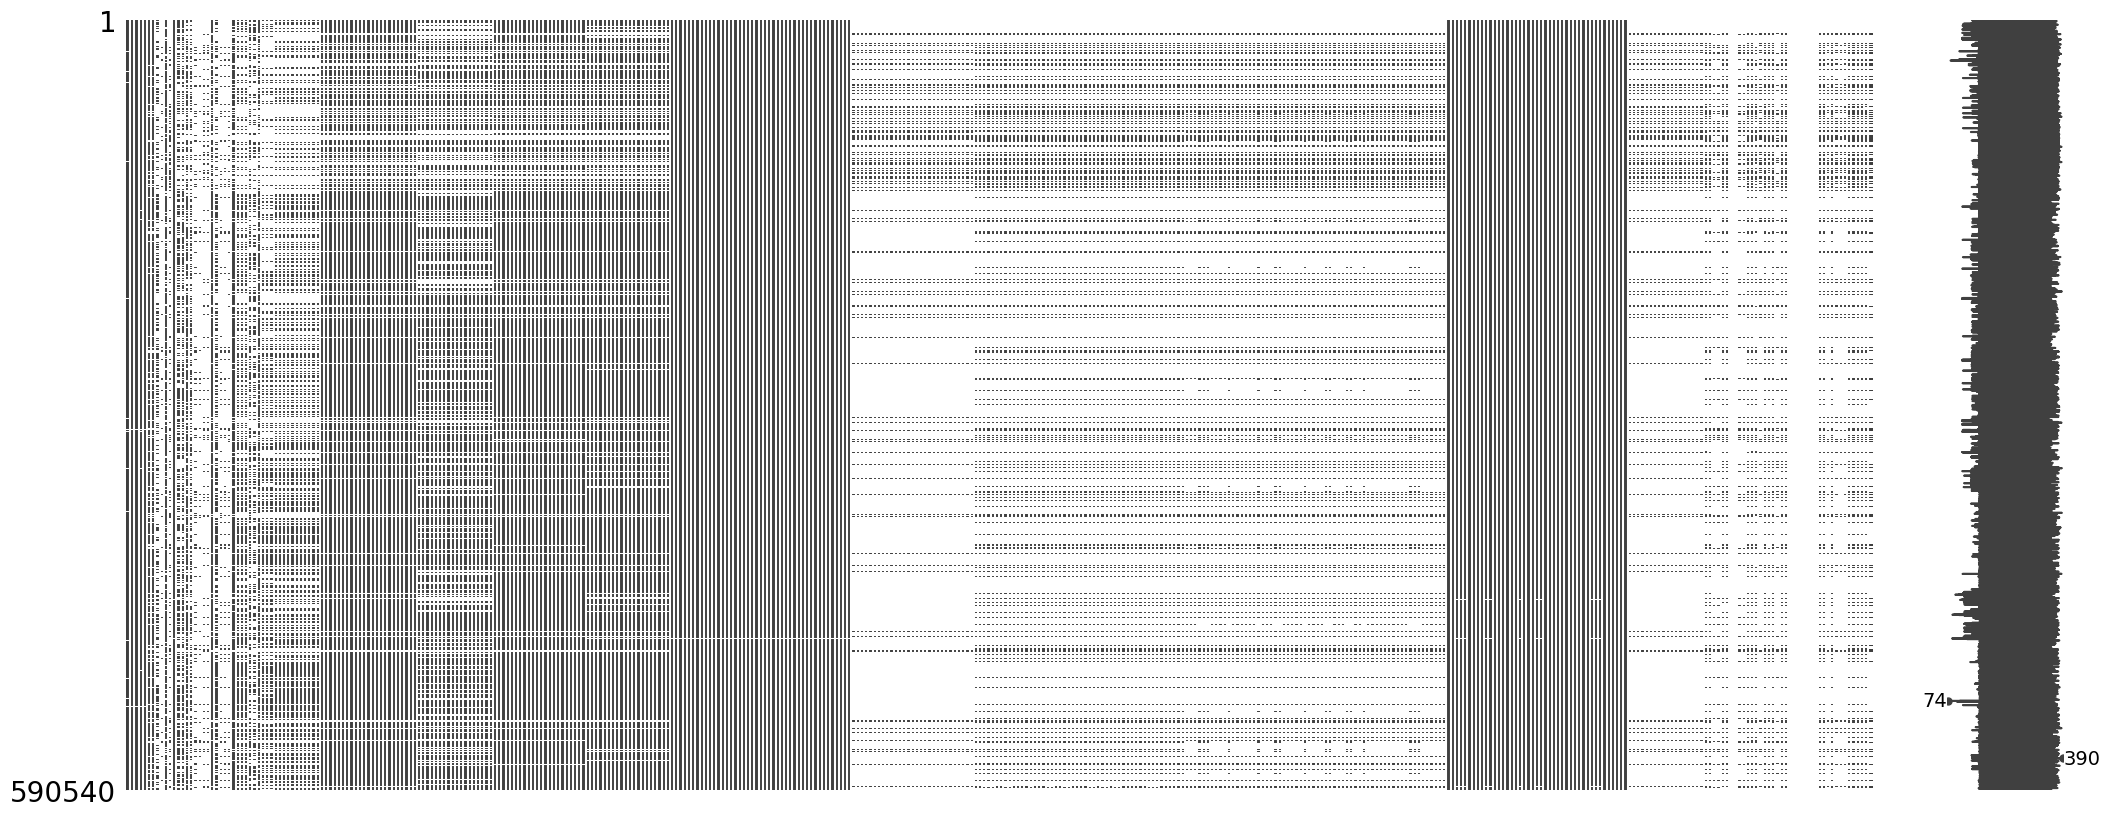

In [9]:
msno.matrix(df= train_df[missing_col_list])

In [10]:
%run Cleaning_utils.ipynb

In [11]:
%run EDA_utils.ipynb

In [12]:
%run Featrue_Engineering_utils.ipynb

### 采用多重插补算法对缺失值进行填充

In [13]:
train_y = train_df['isFraud']
# train_df.drop(labels = ['isFraud'], axis = 1,inplace = True)

In [14]:
#get the str or object type feature names
str_col_list = [x for x in train_df.columns if str(train_df[x].dtype)[:3] not in ['int','flo']]

### encoding these categorical features to digital value firstly for missing values imputing

In [15]:
print(str_col_list,end = "")

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [16]:
for col in str_col_list:
    #根据取值观察，可以采用label encoding
    print(col)
    print(train_df[col].value_counts())
    print('-----------------------------')

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64
-----------------------------
card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
-----------------------------
card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64
-----------------------------
P_emaildomain
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter

In [17]:
for col in str_col_list:
    #根据取值观察，可以采用label encoding
    train_df[col] = Encoder_With_Label(train_df,col)

### 通过MICE算法对数据集进行填充

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(33), int8(1)
memory usage: 580.6 MB


In [19]:
print(missing_col_list,end = "")

['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V

In [20]:
missing_col_cate = [x for x in missing_col_list if x in cate_col_list]
missing_col_cont = [x for x in missing_col_list if x in cont_col_list]

In [21]:
print(missing_col_cate,end = "")

['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [126]:
train_df['isFraud'] = train_y

In [28]:
train_df['card4'].isnull().sum()

1577

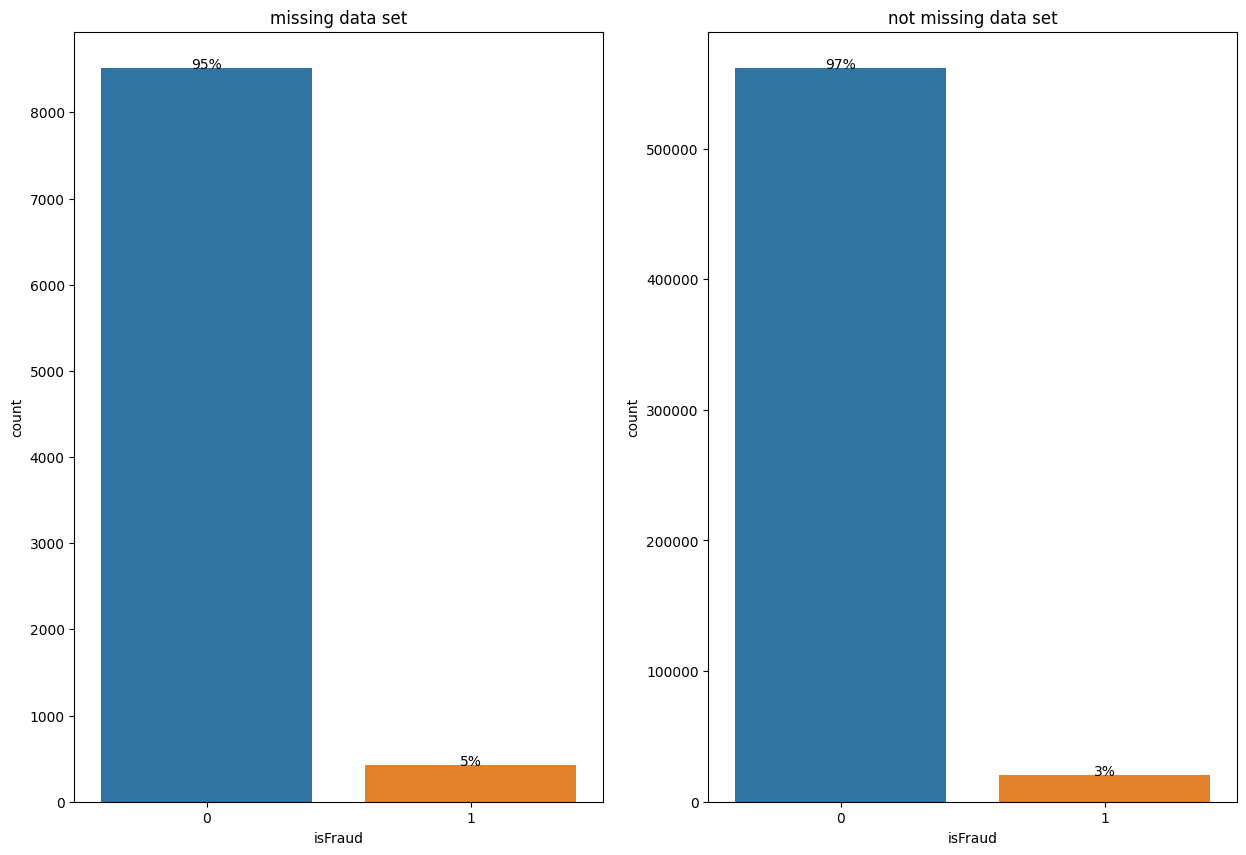

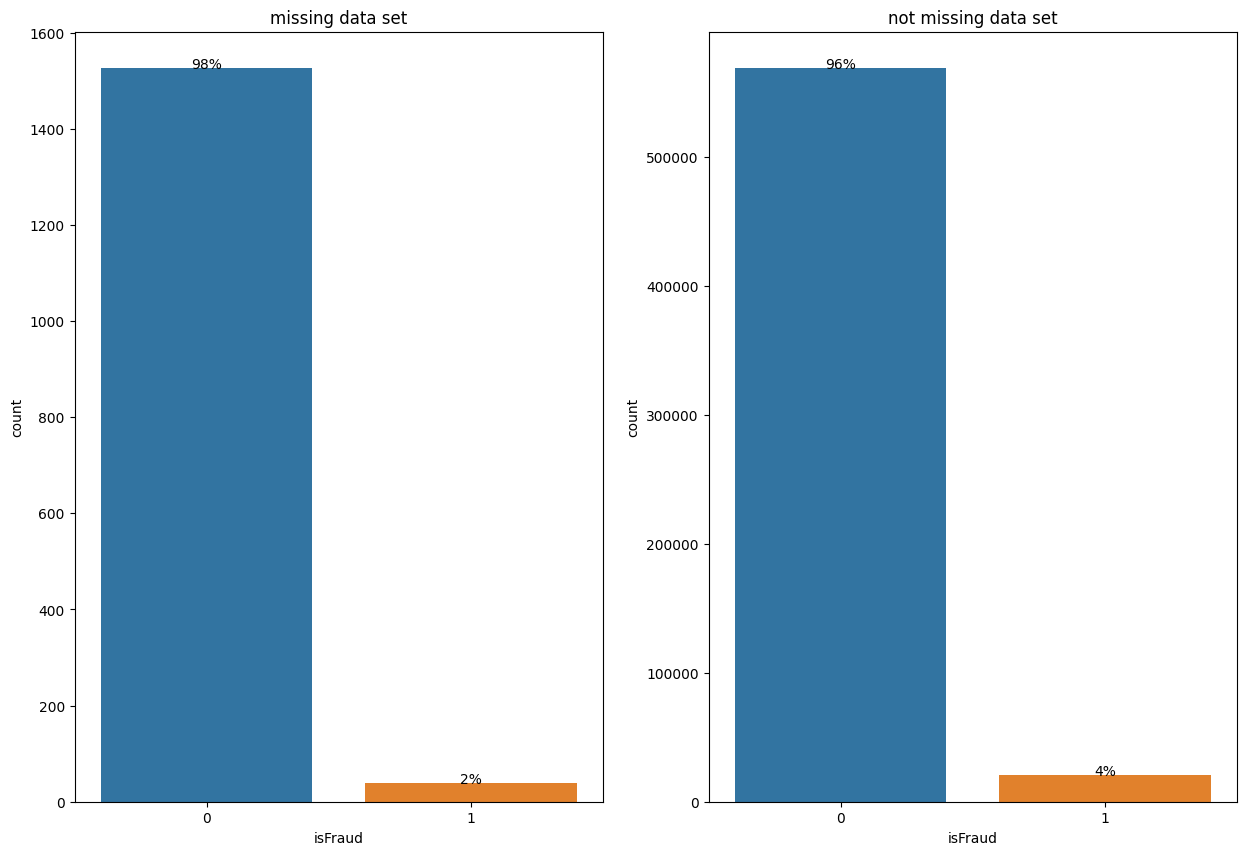

ValueError: min() arg is an empty sequence

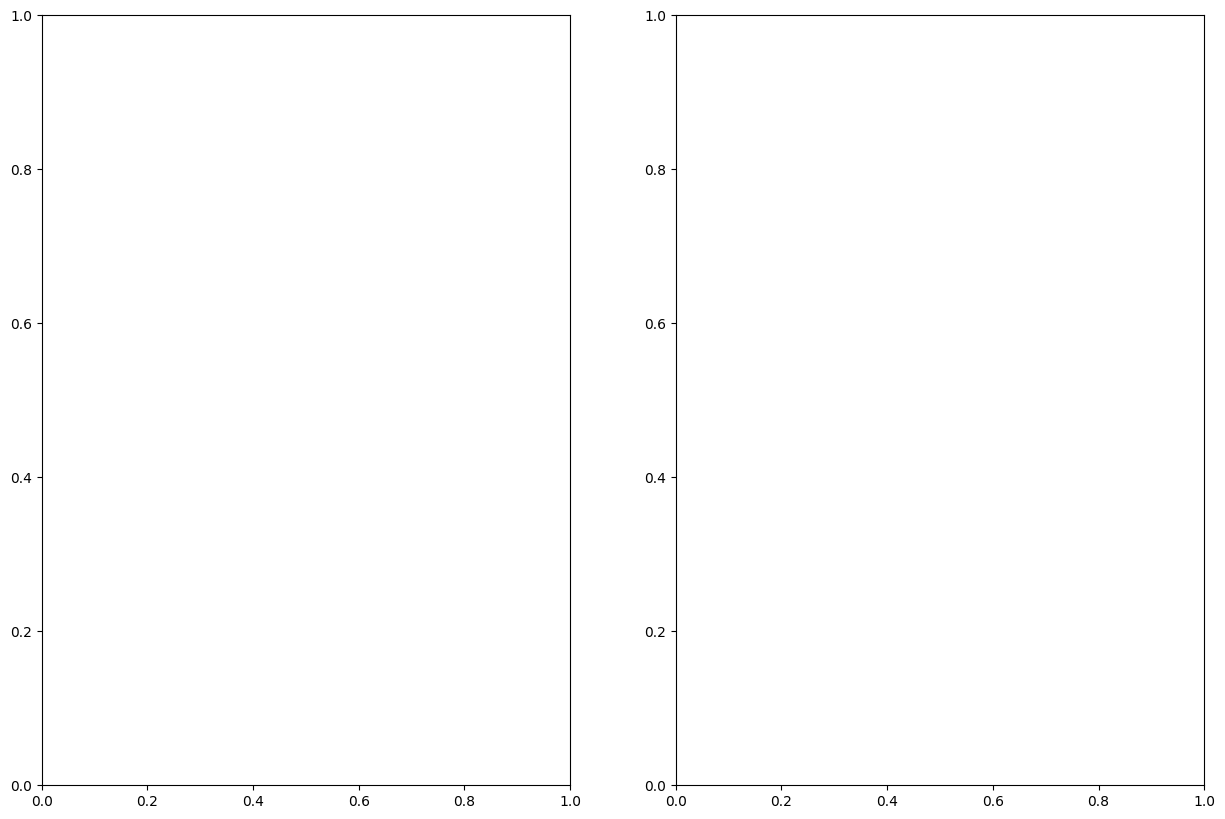

In [129]:
for col in missing_col_cate:
    Missing_Detect_Diff_Distribution(train_df,col,'isFraud')